In [94]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional
import random

users_url = 'https://drive.google.com/uc?id=1V3_mcIpT8Tw9MT2xMEuoTOYo2x16e40Q&export=download'
movies_url = 'https://drive.google.com/uc?id=1a1EefLvuXy8n3mYRkNV5epVfzRQSJX0N&export=download'
ratings_url = 'https://drive.google.com/uc?id=14CThKiJc7u_hmVKCAex4dHmEyx23zVTn&export=download'
links_url = 'https://drive.google.com/uc?id=1T_rC_zGjvxuOUfARQsdjIXHvygrbMnNw&export=download'
df_users = pd.read_csv(users_url, sep='|', encoding='latin-1', header=None, 
                    names=['user_id', 'age', 'gender', 'occupation', 'zipcode'])
df_users['user_id'] = df_users['user_id'] - 1
df_users['stt'] = df_users['user_id']
df_movies = pd.read_csv(movies_url, encoding='latin-1', skiprows=1,
                     names=['movie_id', 'title', 'genres', 'tmdb_id', 'overview', 'posterpath', 'vote_average', 'release_date', 'runtime', 'budget', 'revenue', 'keywords', 'casts', 'director'])
df_links = pd.read_csv(links_url, encoding='latin-1', header=None, 
                    names=['imdb_id', 'imdb_url'])
df_movies['movie_id'] = df_movies['movie_id'] - 1
df_movies['stt'] = df_movies['movie_id']
df_ratings = pd.read_csv(ratings_url, sep='\t', encoding='latin-1', header=None, 
                      names=['user_id', 'movie_id', 'rating', 'timestamp'])
#Merge them poster url and link
df_merged_url = df_movies.merge(df_links[['imdb_id', 'imdb_url']], left_on='movie_id', right_on='imdb_id', how='left')
df_movies['IMDb_URL'] = df_merged_url['imdb_url'].astype(str).str.zfill(7)

In [95]:
rate_train = df_ratings.to_numpy()
rate_train[:, :2] -= 1

users = df_users.set_index('stt').to_dict(orient='index')
movies = df_movies.set_index('stt').to_dict(orient='index')
df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s')
ratings = {(row['user_id'], row['movie_id']): row['rating'] for _, row in df_ratings.iterrows()}

In [96]:
print(f"Số lượng users: {len(users)}")
print(f"Số lượng movies: {len(movies)}")
print(f"Số lượng ratings: {len(ratings)}")

Số lượng users: 943
Số lượng movies: 1663
Số lượng ratings: 100000


In [97]:
class MovieRecommenderEnv:
    def __init__(self, users, movies, ratings, 
                 possible_ratings = [1, 2, 3, 4, 5],
                 exploration_ratio = 0.3):
        self.users = users
        self.movies = movies
        self.ratings = ratings
        self.possible_ratings = possible_ratings
        self.exploration_ratio = exploration_ratio
        self.state = None
        self.user_history = self._build_user_history()
        self.predictions = []
        self.actual_ratings = []
        self._build_cache()

    def _build_cache(self):
        self.user_ratings_cache = {}
        self.movie_ratings_cache = {}
        self.user_means_cache = {}
        self.movie_means_cache = {}
        
        for (user, movie), rating in self.ratings.items():
            if user not in self.user_ratings_cache:
                self.user_ratings_cache[user] = []
            self.user_ratings_cache[user].append(rating)
            if movie not in self.movie_ratings_cache:
                self.movie_ratings_cache[movie] = []
            self.movie_ratings_cache[movie].append(rating)

        for user, ratings in self.user_ratings_cache.items():
            self.user_means_cache[user] = sum(ratings) / len(ratings) if ratings else 3.5
        for movie, ratings in self.movie_ratings_cache.items():
            self.movie_means_cache[movie] = sum(ratings) / len(ratings) if ratings else 3.5

    def _build_user_history(self):
        user_history = {user: [] for user in self.users.keys()}
        for (user, movie), _ in self.ratings.items():
            user_history[user].append(movie)
        return user_history

    def reset(self):
        self.state = self._get_random_state()
        return self.state

    def _get_random_state(self):
        user = random.choice(list(self.users.keys()))
    
        if random.random() < self.exploration_ratio:
            watched_movies = set(self.user_history.get(user, []))
            all_movies = set(self.movies.keys())
            unwatched_movies = list(all_movies - watched_movies)
            
            if unwatched_movies:
                movie = random.choice(unwatched_movies)
                return (user, movie)
        
        movie = random.choice(self.user_history[user])
        return (user, movie)
    
    
    def get_rating(self, user_id, movie_id):
        if (user_id, movie_id) in self.ratings:
            return self.ratings[(user_id, movie_id)]
        else: 
            return None


    def step(self, action):
        if not self.state:
            raise ValueError("Environment chưa được khởi tạo. Gọi reset() trước.")
            
        user, movie = self.state
        true_rating = self.get_rating(user, movie)

        if true_rating is not None:
            reward = self._calculate_reward(true_rating, action)
            self.predictions.append(action)
            self.actual_ratings.append(true_rating)
        else:
            reward = self._calculate_exploration_reward(action, self.state)

        self.state = self._get_random_state()
        
        return self.state, reward

    def _calculate_reward(self, true_rating, predicted_rating):
        error = abs(true_rating - predicted_rating)
        if error == 0:
            return 2
        elif error == 1:
            return 1
        elif error == 2:
            return -1
        else:
            return -2

    def _calculate_exploration_reward(self, action, state):
        user, movie = state
        user_ratings = self.user_ratings_cache.get(user, [])
        movie_ratings = self.movie_ratings_cache.get(movie, [])
        user_mean = self.user_means_cache.get(user, 3.5)
        movie_mean = self.movie_means_cache.get(movie, 3.5)
        
        user_density = min(len(user_ratings) / 100, 1.0) #100000/943 =100
        movie_density = min(len(movie_ratings) / 60, 1.0) #100000/1682 =60
        prediction_confidence = (user_density + movie_density) * 0.5
        if len(user_ratings) < 10 or len(movie_ratings) < 10:
            base_reward = 1.0 if 3 <= action <= 4 else 0.5
        else:
            user_distance = abs(action - user_mean)
            movie_distance = abs(action - movie_mean)
            
            if user_distance <= 1 and movie_distance <= 1:
                base_reward = 1.0
            elif user_distance <= 2 and movie_distance <= 2:
                base_reward = 0.7
            else:
                base_reward = 0.3
        final_reward = base_reward * (0.7 + 0.3 * prediction_confidence)
        if 3 <= action <= 4:
            final_reward *= 1.2
        return min(1.0, final_reward)
    
    
    def evaluate(self):
        if not self.predictions:
            return float('inf')
        return np.sqrt(mean_squared_error(self.actual_ratings, self.predictions))
    

In [98]:
class QTable:
    def __init__(self, default_value):
        self.table = {}
        self.default_value = default_value

    def __getitem__(self, key):
        return self.table.get(key, self.default_value)

    def __setitem__(self, key, value):
        self.table[key] = value

    def get_max_q_value(self, state, actions):
        return max(self[state, action] for action in actions)


In [99]:

class QLearningAgent:
    def __init__(
        self,
        env: MovieRecommenderEnv,
        learning_rate = 0.1,
        discount_factor = 0.95,
        epsilon = 0.1,
        max_steps = 100,
        default_q = 1.0
    ):
        self.env = env
        self.alpha = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.max_steps = max_steps
        self.q_table = QTable(default_q)

    def train(self, n_episodes = 10000):
        scores = []
        for episode in range(n_episodes):
            state = self.env.reset()
            score = 0
            prev_state = None
            prev_action = None
            
            for _ in range(self.max_steps):
                action = self._select_action(state)
                next_state, reward = self.env.step(action)
                score += reward
                
                if prev_state is not None:
                    self._update_q_value(prev_state, prev_action, state, reward)
                
                prev_state, prev_action = state, action
                state = next_state
            
            if episode % 100 == 0:
                scores.append(score)
                rmse = self.env.evaluate()
                print(f'Episode {episode}, RMSE: {rmse:.4f}, score: {score:.4f}')
                
        return scores

    def _select_action(self, state):
        """Select action using epsilon-greedy policy"""
        if np.random.random() < self.epsilon:
            return np.random.choice(self.env.possible_ratings)
        
        q_values = [self.q_table[state, action] for action in self.env.possible_ratings]
        return self.env.possible_ratings[np.argmax(q_values)]

    def _update_q_value(self, state, action, next_state, reward ):
        """Update Q-value using Q-learning update rule"""
        current_q = self.q_table[state, action]
        max_next_q = self.q_table.get_max_q_value(next_state, self.env.possible_ratings)
        new_q = current_q + self.alpha * (reward + self.gamma * max_next_q - current_q)
        self.q_table[state, action] = new_q

    def recommend_movies(self, user_id, k = 5):
        # Get unrated movies for user
        rated_movies = set(self.env.user_history.get(user_id, []))
        all_movies = set(self.env.movies.keys())
        unrated_movies = list(all_movies - rated_movies)

        # Get predictions for each unrated movie
        recommendations = []
        for movie_id in unrated_movies:
            state = (user_id, movie_id)
            q_values = [self.q_table[state, action] for action in self.env.possible_ratings]
            pred_rating = self.env.possible_ratings[np.argmax(q_values)]
            max_q = max(q_values)
            recommendations.append((movie_id, pred_rating, max_q))

        recommendations.sort(key=lambda x: (x[1], x[2]), reverse=True)
        return recommendations[:k]



In [100]:
def plot_training_progress(scores):
    """Plot training progress"""
    plt.figure(figsize=(10, 6))
    plt.plot(scores)
    plt.title('Q-Learning Training Progress')
    plt.xlabel('Episode (x100)')
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()


In [101]:

env = MovieRecommenderEnv(users, movies, ratings)
agent = QLearningAgent(
        env,
        learning_rate=0.15,
        discount_factor=0.85,
        epsilon=0.4,
        max_steps=100
    )

scores = agent.train(n_episodes=20000)


Episode 0, RMSE: 2.5548, score: -43.0289
Episode 100, RMSE: 2.4881, score: -9.3748
Episode 200, RMSE: 2.4602, score: -28.9940
Episode 300, RMSE: 2.4484, score: -29.9936
Episode 400, RMSE: 2.4282, score: -30.2000
Episode 500, RMSE: 2.4154, score: -17.2881
Episode 600, RMSE: 2.4045, score: -36.3974
Episode 700, RMSE: 2.3897, score: -17.4613
Episode 800, RMSE: 2.3756, score: -13.9224
Episode 900, RMSE: 2.3647, score: -13.5067
Episode 1000, RMSE: 2.3542, score: -9.7752
Episode 1100, RMSE: 2.3443, score: -10.4585
Episode 1200, RMSE: 2.3337, score: 22.4324
Episode 1300, RMSE: 2.3252, score: -18.3053
Episode 1400, RMSE: 2.3163, score: -33.7466
Episode 1500, RMSE: 2.3077, score: -28.6360
Episode 1600, RMSE: 2.2992, score: 4.6003
Episode 1700, RMSE: 2.2901, score: -3.3321
Episode 1800, RMSE: 2.2823, score: -11.9560
Episode 1900, RMSE: 2.2752, score: -5.1323
Episode 2000, RMSE: 2.2690, score: -7.7493
Episode 2100, RMSE: 2.2622, score: -27.5702
Episode 2200, RMSE: 2.2563, score: 24.7861
Episode 2

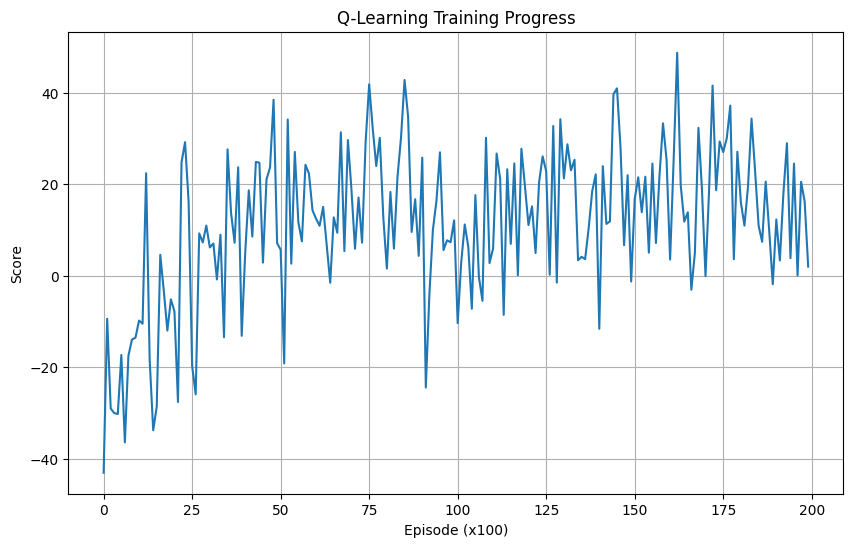

In [102]:
plot_training_progress(scores)

In [103]:
user_id = 0  # Example user
recommendations = agent.recommend_movies(user_id, k=500)

# Print recommendations
print("\nTop 5 movie recommendations for user", user_id)
for movie_id, pred_rating, q_value in recommendations:
    movie_title = movies[movie_id]['title']
    print(f"Movie: {movie_title}, Predicted Rating: {pred_rating:.1f}, Q-value: {q_value:.2f}")


Top 5 movie recommendations for user 0
Movie: Beautiful Thing, Predicted Rating: 5.0, Q-value: 1.38
Movie: Son in Law, Predicted Rating: 5.0, Q-value: 1.32
Movie: Junichi Yaoi's UFO On-site Coverage Vol.3: Is there a Child between a Human and an Alien - Explore the Mystery of the Underground Secret Base!!, Predicted Rating: 5.0, Q-value: 1.29
Movie: Open Season, Predicted Rating: 5.0, Q-value: 1.28
Movie: Prisoner of the Mountains, Predicted Rating: 5.0, Q-value: 1.19
Movie: Major Payne, Predicted Rating: 5.0, Q-value: 1.19
Movie: The Birds, Predicted Rating: 5.0, Q-value: 1.19
Movie: Love Affair, Predicted Rating: 5.0, Q-value: 1.19
Movie: American Buffalo, Predicted Rating: 5.0, Q-value: 1.17
Movie: Fire on the Mountain, Predicted Rating: 5.0, Q-value: 1.13
Movie: My Man Godfrey, Predicted Rating: 5.0, Q-value: 1.13
Movie: That Thing You Do!, Predicted Rating: 5.0, Q-value: 1.13
Movie: Balto, Predicted Rating: 5.0, Q-value: 1.13
Movie: Love Serenade, Predicted Rating: 5.0, Q-value: 